## 🎬 Przedstawienie problemu

Zacznijmy od krótkiego filmu, który zainspirował nasz projekt.  
Pada w nim intrygujące pytanie


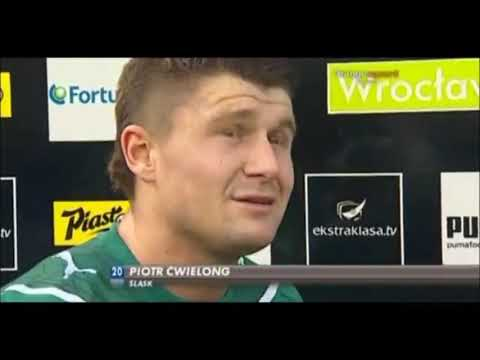

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Z44BZeF-ovk', width=640, height=360)

## ⚽ Wprowadzenie

<img src="https://upload.wikimedia.org/wikipedia/en/f/f2/Premier_League_Logo.svg" alt="Premier League" width="150">

W tym projekcie analizujemy, czy pora meczu wpływa na jego przebieg – a konkretnie:  
**czy w niedzielę o 17:00 gra się trudniej?**

Bazujemy na zbiorze danych **Premier League Past 3 Seasons** z Kaggle, zawierającym szczegółowe statystyki z sezonów **2022/2023 – 2024/2025**.

---

### 🔍 Nasze pytania:

- Czy niedzielne mecze o 17:00 różnią się od innych pod względem statystyk?
- Czy widać różnice w oczekiwanych bramkach (xG) oraz bramkach?
- Czy dzień tygodnia i godzina meczu mają wpływ na jego przebieg?
- Czy miesiąc rozgrywania meczu ma wpływ na jego atrkacyjność?

Celem jest eksploracyjna analiza danych i wizualne przedstawienie odpowiedzi na te pytania.


Najpierw zainstalujmy niezbędne pakiety

In [4]:
!pip install kagglehub
import kagglehub
import pandas as pd
from pathlib import Path, PurePath
import functions as f
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns 
import numpy as np


## Przygotowanie i czyszczenie danych

Zanim przejdziemy do analizy głównej tezy, musimy przygotować dane. W tej sekcji:
- wczytamy plik CSV z danymi meczów Premier League,
- sformatujemy kolumny z datą i godziną,
- dodamy nowe kolumny przydatne do analizy, takie jak: dzień tygodnia, czy mecz był w niedzielę, czy był grany o 17:00 oraz czy spełnia warunki tzw. "trudnego czasu".


### Import danych i wstępna obróbka

Wczytujemy dane z KaggleHub, ustawiamy Pandas tak, aby wyświetlał wszystkie kolumny, a następnie kopiujemy oryginalną ramkę danych `df_raw` do roboczej wersji `df`, z którą będziemy dalej pracować. Usuwamy zbędne kolumny takie jak matchday jest to numer kolejki ligowej, attendance - liczba widzów, referee - sędzia główny, stadium - nazwa stadionu, result - jest dla nas kompletnie bez znaczenia kto wygrał oraz *additional stats - jest to link do strony ze szczegółami. 


In [5]:
pd.set_option('display.max_columns', 18)

path = kagglehub.dataset_download("filippomonte/premier-league-past-3-seasons")
file = PurePath(Path(path).joinpath('PremierLeagueMatches.csv'))
df_raw = pd.read_csv(file)
df_raw.columns = [x.lower() for x in df_raw.columns]
df = df_raw
cols_to_drop = ['matchday',  'attendance', 'referee', 'stadium', 'result', '*additional stats']
df.drop(columns=cols_to_drop,inplace=True)


In [12]:
nan_count = df.isna().sum()
print(nan_count)

date          0
time          0
home team     0
homescore    91
homexg       91
awayscore    91
awayxg       91
away team     0
dtype: int64


In [7]:
df = df_raw.dropna(subset=['homescore'])
nan_count = df.isna().sum()
print(nan_count)


date         0
time         0
home team    0
homescore    0
homexg       0
awayscore    0
awayxg       0
away team    0
dtype: int64


## Przygotowanie i czyszczenie danych

Na początku wczytujemy dane z pliku CSV i konwertujemy kolumnę z datą na typ datetime. Następnie dodajemy zmienne pomocnicze, które ułatwią dalszą analizę:

- _Dzień tygodnia_ (`day_of_week`) — informacja o dniu, w którym odbył się mecz.
- _Czy mecz odbył się w niedzielę_ (`sunday`).
- _Zaokrąglenie godziny rozpoczęcia meczu do pełnej godziny_ - do 30 min w dół, od 31 w górę
- _Czy mecz rozpoczął się w godzinach 16-18_, traktowane jako godzina 17 (`seventeen`).
- _Suma zdobytych goli_ (`total_goals`).
- _Suma oczekiwanych goli_ (`total_xg`).
- _Wskaźnik „trudnego czasu”_ (`hard_time`) — mecze niedzielne o 17:00.



In [8]:
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.day_name()
df['sunday']=df['day_of_week'].apply(lambda x: 'Yes' if x=='Sunday' else 'No')
df['pure_hour'] = pd.to_datetime(df['time'], format='%H:%M')
df['pure_hour']=df['pure_hour'].apply(f.hours).dt.hour
df['seventeen']=df['pure_hour'].apply(lambda x: 'Yes' if x>=16 and x<=18 else 'No')
df['total_goals']=df['homescore']+df['awayscore']
df['total_xg']=df['homexg']+df['awayxg']
df['hard_time']=df.apply(lambda row: 'Yes' if row['sunday']=='Yes' and row['seventeen']=='Yes' else 'No', axis=1)


C:\Users\mateu\AppData\Local\Temp\ipykernel_11788\2579333999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Users\mateu\AppData\Local\Temp\ipykernel_11788\2579333999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['date'].dt.day_name()
C:\Users\mateu\AppData\Local\Temp\ipykernel_11788\2579333999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

---

## Sprawdźmy główną tezę

**Czy mecze w niedzielę o 17:00 są trudniejsze?**

Najpierw sprawdźmy, czy **liczba takich meczów jest odpowiednio duża**, aby móc wyciągać wiarygodne wnioski.

---


In [9]:
df.groupby('hard_time').size()

hard_time
No     950
Yes     99
dtype: int64

---

Prawie **100 meczów** — uważamy, że to **dostatecznie liczna próbka** do analizy.

---




### Analiza średniej liczby goli w zależności od trudności czasu meczu (`hard_time`)

Poniższy kod oblicza średnią liczbę goli dla meczów w różnych kategoriach czasu (`hard_time`) i przedstawia te wartości na wykresie słupkowym.




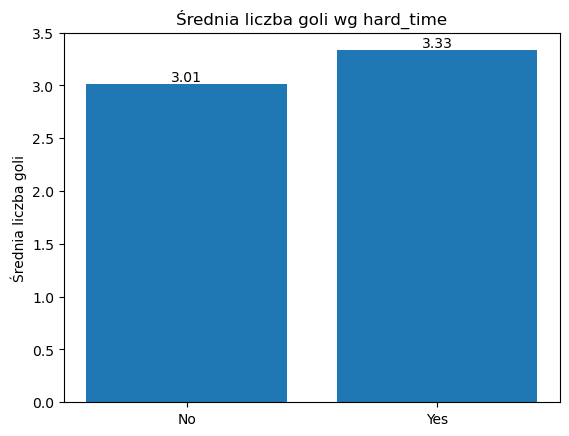

In [10]:
means = df.groupby('hard_time')['total_goals'].mean()

# Rysowanie wykresu
fig, ax = plt.subplots()
bars = ax.bar(means.index, means.values)

# Dodanie etykiet z wartością nad słupkami
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height:.2f}', ha='center', va='bottom')

ax.set_ylabel('Średnia liczba goli')
ax.set_title('Średnia liczba goli wg hard_time')

plt.show()

---

Teoria Piotrka się nie potwierdza, ale sprawdźmy, czy może to nie efekt padania **przypadkowych bramek**, a wizualnie mecz warto ocenić przez pryzmat **expected goals (xG)**.

---


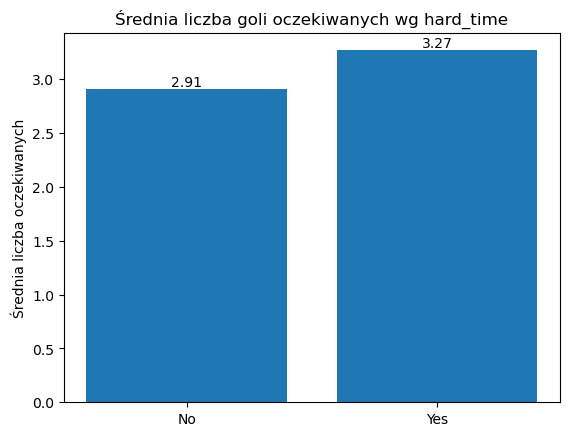

In [11]:
means = df.groupby('hard_time')['total_xg'].mean()

# Rysowanie wykresu
fig, ax = plt.subplots()
bars = ax.bar(means.index, means.values)

# Dodanie etykiet z wartością nad słupkami
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height:.2f}', ha='center', va='bottom')

ax.set_ylabel('Średnia liczba oczekiwanych')
ax.set_title('Średnia liczba goli oczekiwanych wg hard_time')
plt.show()

---

**Niestety, również tutaj nie da się jednoznacznie stwierdzić, że to gorszy czas do gry w piłkę.**

---

Poszukajmy zatem jakichkolwiek przesłanek, sprawdzając kolejno:

- **Powyższe teorie** osobno dla **niedzieli** oraz dla godziny **17:00**  
- **Rozkłady** liczby goli oraz oczekiwanych goli (*expected goals*) w poszczególnych miesiącach z uwzględnieniem parametru `hard_time`  
- **Średnią liczbę goli** zdobywanych przez poszczególne drużyny oraz ich **częstotliwość gry w niedzielę**  
- Poszukajmy również nowej definicji **`hard_time`**

---


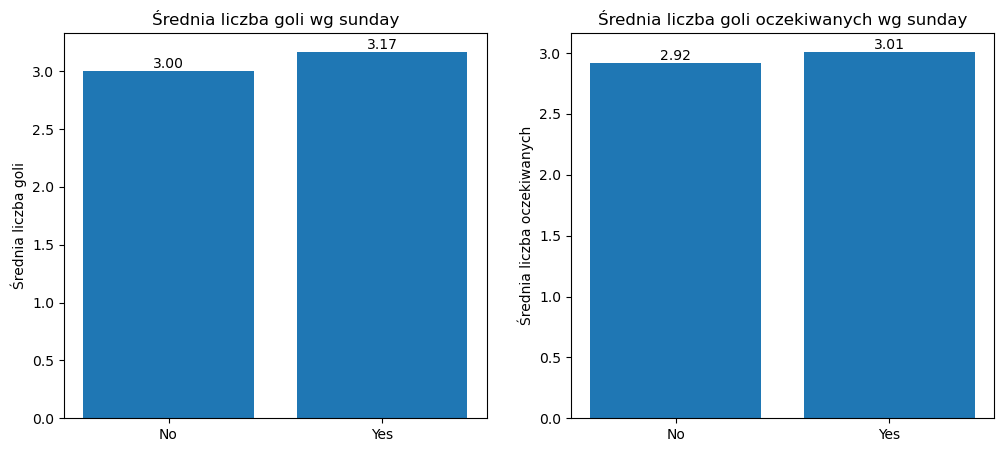

In [12]:
# Średnie
goals_mean = df.groupby('sunday')['total_goals'].mean()
xg_mean = df.groupby('sunday')['total_xg'].mean()

# Rysowanie obok siebie
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Wykres 1 – total_goals
bars1 = axs[0].bar(goals_mean.index, goals_mean.values)
axs[0].set_title('Średnia liczba goli wg sunday')
axs[0].set_ylabel('Średnia liczba goli')

for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height,
                f'{height:.2f}', ha='center', va='bottom')

# Wykres 2 – total_xg
bars2 = axs[1].bar(xg_mean.index, xg_mean.values)
axs[1].set_title('Średnia liczba goli oczekiwanych wg sunday')
axs[1].set_ylabel('Średnia liczba oczekiwanych')

for bar in bars2:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height,
                f'{height:.2f}', ha='center', va='bottom')


plt.show()






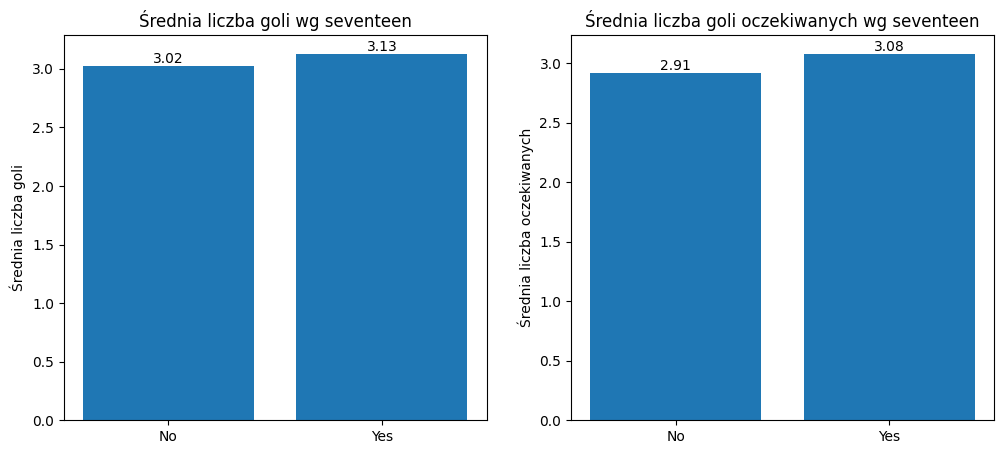

In [24]:
# Średnie
goals_mean = df.groupby('seventeen')['total_goals'].mean()
xg_mean = df.groupby('seventeen')['total_xg'].mean()

# Rysowanie obok siebie
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Wykres 1 – total_goals
bars1 = axs[0].bar(goals_mean.index, goals_mean.values)
axs[0].set_title('Średnia liczba goli wg seventeen')
axs[0].set_ylabel('Średnia liczba goli')

for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height,
                f'{height:.2f}', ha='center', va='bottom')

# Wykres 2 – total_xg
bars2 = axs[1].bar(xg_mean.index, xg_mean.values)
axs[1].set_title('Średnia liczba goli oczekiwanych wg seventeen')
axs[1].set_ylabel('Średnia liczba oczekiwanych')

for bar in bars2:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height,
                f'{height:.2f}', ha='center', va='bottom')


plt.show()

**Wnioski:**  
Zarówno niedziela, jak i godzina 17 to terminy z wyższą liczbą goli i expected goals, co przeczy teorii o tym, ze w piłkę gra się wtedy gorzej


### Dodajemy kolumne `month` do DataFrame i przeprowadzamy analizę średniej liczby goli i oczekiwanych goli wg miesiąca i `hard_time`

In [13]:
df['month'] = pd.to_datetime(df['date']).dt.month

C:\Users\mateu\AppData\Local\Temp\ipykernel_11788\1439146429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['date']).dt.month


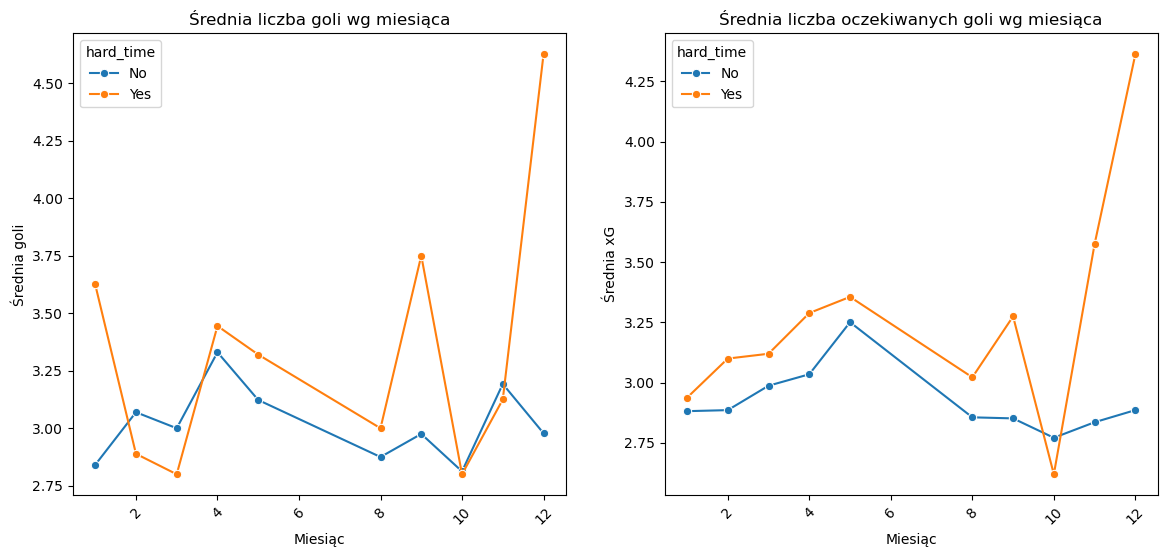

In [14]:
df_goals = df.groupby(['month', 'hard_time'])['total_goals'].mean().reset_index()
df_xg = df.groupby(['month', 'hard_time'])['total_xg'].mean().reset_index()

# Rysowanie dwóch wykresów
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Wykres 1 – realne gole
sns.lineplot(data=df_goals, x='month', y='total_goals', hue='hard_time', marker='o', ax=axs[0])
axs[0].set_title('Średnia liczba goli wg miesiąca')
axs[0].set_ylabel('Średnia goli')
axs[0].set_xlabel('Miesiąc')
axs[0].tick_params(axis='x', rotation=45)

# Wykres 2 – expected goals
sns.lineplot(data=df_xg, x='month', y='total_xg', hue='hard_time', marker='o', ax=axs[1])
axs[1].set_title('Średnia liczba oczekiwanych goli wg miesiąca')
axs[1].set_ylabel('Średnia xG')
axs[1].set_xlabel('Miesiąc')
axs[1].tick_params(axis='x', rotation=45)


plt.show()



---

## Możliwy wpływ miesiąca na wyniki w hard_time

Wywiad mógł pochodzić z lutego lub marca — właśnie wtedy w **hard_time** pada mniej goli. Alternatywnie, w październiku mecze wydają się mniej widowiskowe, co również może mieć znaczenie.


---


---

## Analiza średniej liczby goli i expected goals w podziale na dni tygodnia

Aby lepiej zrozumieć rozkład goli i oczekiwanych goli w różnych dniach tygodnia, przekształciliśmy dane a następnie wyliczyliśmy średnie wartości dla każdej metryki w każdym dniu.

Na wykresie poniżej widzimy porównanie średniej liczby strzelonych goli i expected goals (xG) w poszczególnych dniach tygodnia.

---


C:\Users\mateu\AppData\Local\Temp\ipykernel_11788\2075113337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)
C:\Users\mateu\AppData\Local\Temp\ipykernel_11788\2075113337.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_day = df_long.groupby(['day_of_week', 'metric'])['value'].mean().reset_index()


     day_of_week       metric  value
0         Friday  total_goals    2.0
1       Saturday  total_goals    4.0
2       Saturday  total_goals    5.0
3       Saturday  total_goals    2.0
4       Saturday  total_goals    3.0
...          ...          ...    ...
2093    Saturday     total_xg    1.7
2094    Saturday     total_xg    2.4
2095      Sunday     total_xg    1.1
2096      Sunday     total_xg    1.9
2097      Sunday     total_xg    1.9

[2098 rows x 3 columns]


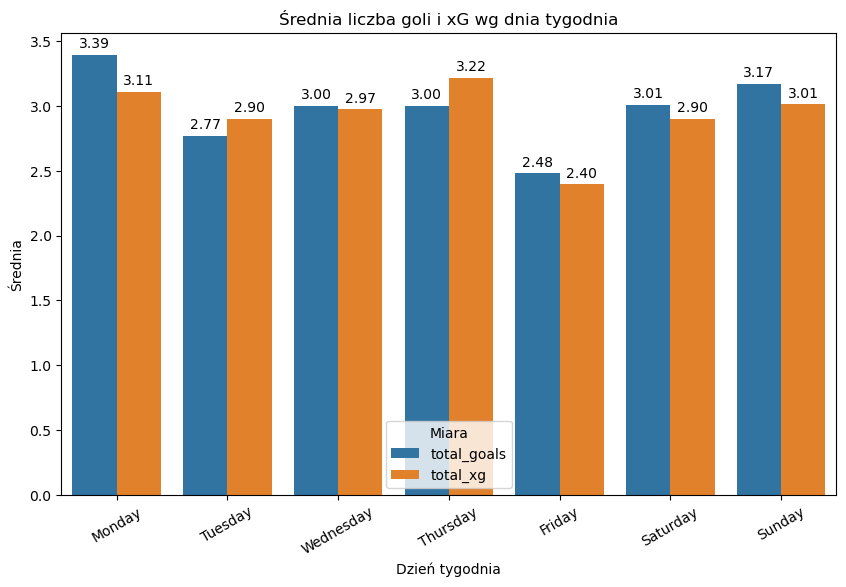

In [16]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)

# Przekształcenie danych do formatu w którym metryki wpadają do kolumn
df_long = pd.melt(
    df,
    id_vars=['day_of_week'],
    value_vars=['total_goals', 'total_xg'],
    var_name='metric',
    value_name='value'
)

print(df_long)

# Grupowanie – średnia
mean_by_day = df_long.groupby(['day_of_week', 'metric'])['value'].mean().reset_index()

# Rysowanie
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_by_day, x='day_of_week', y='value', hue='metric')

# Etykiety nad słupkami
for container in plt.gca().containers:
    for bar in container:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.03, f'{height:.2f}', ha='center', va='bottom')

plt.title('Średnia liczba goli i xG wg dnia tygodnia')
plt.ylabel('Średnia')
plt.xlabel('Dzień tygodnia')
plt.xticks(rotation=30)
plt.legend(title='Miara')

plt.show()

---

## Piątek jako kandydat na nowy hard time


Aby to dokładniej zbadać, analizujemy teraz rozkład goli i xG w piątki, rozbitych na miesiące.

---


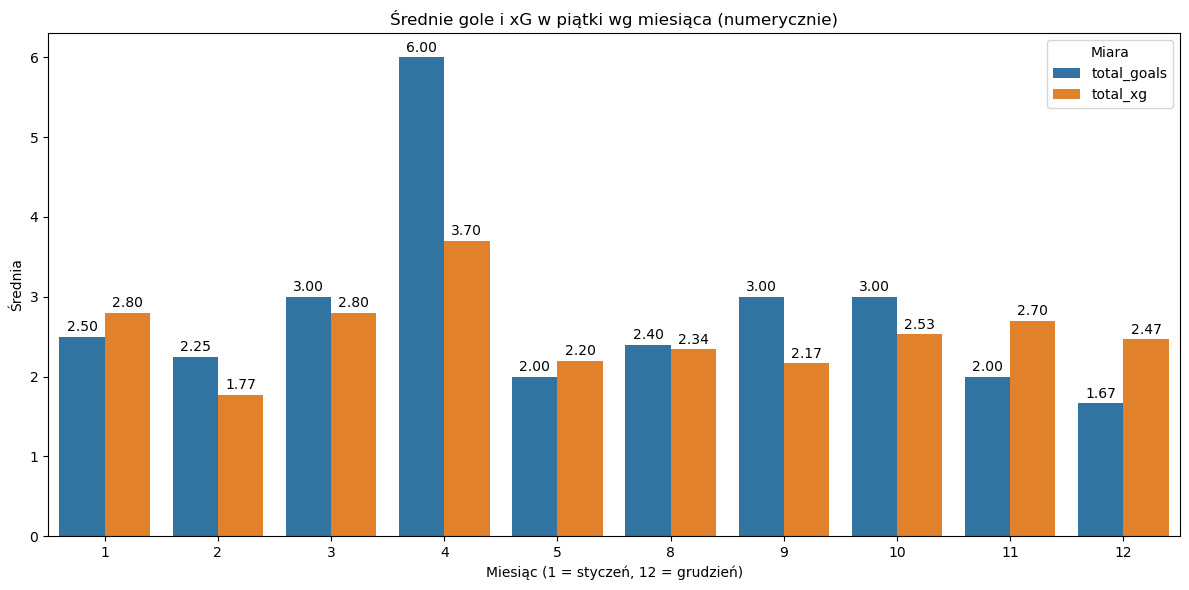

In [17]:
# Filtrowanie tylko piątków
friday_df = df[df['day_of_week'] == 'Friday'].copy()

# Melted format (total_goals i total_xg w jednej kolumnie)
friday_melted = pd.melt(
    friday_df,
    id_vars=['month'],
    value_vars=['total_goals', 'total_xg'],
    var_name='metric',
    value_name='value'
)

# Grupowanie: średnie w danym miesiącu
friday_grouped = friday_melted.groupby(['month', 'metric'])['value'].mean().reset_index()

# Rysowanie
plt.figure(figsize=(12, 6))
sns.barplot(data=friday_grouped, x='month', y='value', hue='metric')

# Etykiety nad słupkami
for container in plt.gca().containers:
    for bar in container:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.03, f'{height:.2f}', ha='center', va='bottom')

plt.title('Średnie gole i xG w piątki wg miesiąca (numerycznie)')
plt.ylabel('Średnia')
plt.xlabel('Miesiąc (1 = styczeń, 12 = grudzień)')
plt.xticks(rotation=0)
plt.legend(title='Miara')
plt.tight_layout()
plt.show()

---

## Analiza piątkowych meczów wg miesiąca

Na podstawie wykresu można zauważyć, że:

- Najnudniejsze piątkowe mecze wizualnie wypadają w **lutym**.
- Najwięcej zmarnowanych sytuacji przez piłkarzy przypada na **listopad i grudzień**.
- Najwięcej „przypadkowych” bramek pada w **kwietniu**.

Aby przejść do dalszej analizy, przygotowujemy dane osobno dla gospodarzy i gości, łącząc je w jeden zbiór do bardziej szczegółowych badań.

---


In [18]:
# Dane gospodarzy
df_home = df[['date', 'home team', 'homescore', 'homexg', 'hard_time', 'day_of_week', 'month']].copy()
df_home.rename(columns={
    'home team': 'team',
    'homescore': 'goals',
    'homexg': 'xg'
}, inplace=True)

# Dane gości
df_away = df[['date', 'away team', 'awayscore', 'awayxg', 'hard_time', 'day_of_week', 'month']].copy()
df_away.rename(columns={
    'away team': 'team',
    'awayscore': 'goals',
    'awayxg': 'xg'
}, inplace=True)

# Łączenie
df_teams = pd.concat([df_home, df_away], ignore_index=True)

---

## Statystyki drużyn

Ponizszy fragment kodu:

- Oblicza łączną liczbę meczów rozegranych przez każdą drużynę.
- Wylicza średnią liczbę goli i średnie oczekiwane gole (xG) na mecz dla każdej drużyny.
- Oblicza odsetek meczów rozegranych przez drużyny w warunkach określonych jako **hard_time**.
- Oblicza odsetek meczów rozegranych przez drużyny w piątki.
- Scala te statystyki w jedną tabelę, która pozwoli na dalszą analizę wpływu czasu rozgrywki i warunków meczu na wyniki drużyn.

---



In [19]:
# Liczba meczów każdej drużyny
total_matches = df_teams.groupby('team').size().rename('matches')

# Średnie gole i xG
avg_goals = df_teams.groupby('team')['goals'].mean().rename('avg_goals')
avg_xg = df_teams.groupby('team')['xg'].mean().rename('avg_xg')

# Odsetek meczów w hard_time
hard_pct = df_teams[df_teams['hard_time'] == 'Yes'].groupby('team').size() / total_matches
hard_pct = hard_pct.rename('hard_time_pct').fillna(0)

# Odsetek meczów w piątek
friday_pct = df_teams[df_teams['day_of_week'] == 'Friday'].groupby('team').size() / total_matches
friday_pct = friday_pct.rename('friday_pct').fillna(0)

# Scalanie wszystkiego razem
team_stats = pd.concat([avg_goals, avg_xg, hard_pct, friday_pct], axis=1).reset_index()
#print(team_stats)

| Drużyna          | Średnia goli | Średnie xG | % meczów w hard_time | % meczów w piątki |
|------------------|--------------|------------|----------------------|-------------------|
| Arsenal          | 2.21         | 1.83       | 20.0%                | 2.86%             |
| Aston Villa      | 1.60         | 1.47       | 7.62%                | 2.86%             |
| Bournemouth      | 1.32         | 1.40       | 2.86%                | 0.00%             |
| Brentford        | 1.56         | 1.52       | 2.86%                | 3.81%             |
| Brighton         | 1.67         | 1.65       | 3.81%                | 3.81%             |
| Burnley          | 1.08         | 1.07       | 2.63%                | 5.26%             |
| Chelsea          | 1.60         | 1.72       | 13.33%               | 2.86%             |
| Crystal Palace   | 1.28         | 1.27       | 1.92%                | 1.92%             |
| Everton          | 1.01         | 1.24       | 3.81%                | 0.95%             |
| Fulham           | 1.46         | 1.30       | 3.81%                | 3.81%             |
| Ipswich Town     | 0.97         | 0.93       | 6.90%                | 3.45%             |
| Leeds United     | 1.26         | 1.25       | 5.26%                | 2.63%             |
| Leicester City   | 1.13         | 1.13       | 1.49%                | 4.48%             |
| Liverpool        | 2.19         | 2.13       | 24.76%               | 0.95%             |
| Luton Town       | 1.37         | 1.11       | 7.89%                | 10.53%            |
| Manchester City  | 2.33         | 2.00       | 20.00%               | 0.95%             |
| Manchester Utd   | 1.45         | 1.55       | 22.86%               | 0.95%             |
| Newcastle Utd    | 1.92         | 1.87       | 10.58%               | 0.96%             |
| Nott'ham Forest  | 1.30         | 1.20       | 6.67%                | 4.76%             |
| Sheffield Utd    | 0.92         | 1.02       | 7.89%                | 5.26%             |
| Southampton      | 0.85         | 0.97       | 1.49%                | 4.48%             |
| Tottenham        | 1.90         | 1.64       | 19.05%               | 1.90%             |
| West Ham         | 1.29         | 1.32       | 8.57%                | 1.90%             |
| Wolves           | 1.15         | 1.10       | 3.81%                | 0.95%             |


---

## Podsumowanie statystyk drużyn

- **Średnia liczba goli (avg_goals)** na mecz waha się od około 0.85 (Southampton) do ponad 2.3 (Manchester City).
- **Średnia liczba oczekiwanych goli (avg_xg)** jest generalnie bliska średniej liczbie goli, co wskazuje na dobre modele obliczeniowe.
- **Odsetek meczów w warunkach hard_time** jest różny dla drużyn – najwyższy dla Liverpoolu (ok. 25%), Manchesteru United (23%), Arsenalu i Manchesteru City (po 20%), co oznacza, że te drużyny często grają w "trudnych" warunkach.
- **Odsetek meczów rozgrywanych w piątki** jest zazwyczaj niski (zwykle poniżej 5%), wyjątkiem jest Luton Town, które gra ponad 10% swoich meczów w piątki.
- Te różnice mogą być punktem wyjścia do analizy, czy np. częstsza gra w piątkowe wieczory lub w hard_time ma wpływ na wyniki poszczególnych drużyn.

---


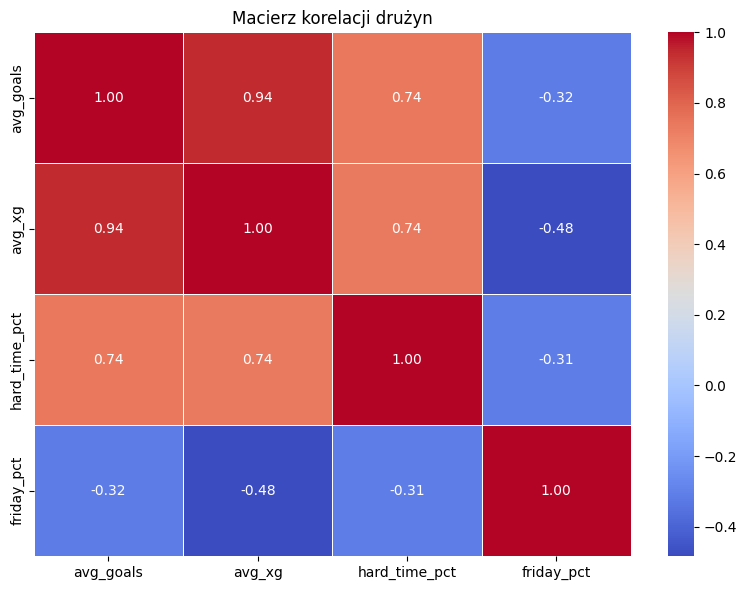

In [38]:
corr = team_stats[['avg_goals', 'avg_xg', 'hard_time_pct', 'friday_pct']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Macierz korelacji drużyn')
plt.tight_layout()
plt.show()

Powyższa macierz korealcji wskazuje, zgodnie z oczekiwaniami - wysoka korelacja między expected goals i goals. W niedzielę pada więcej goli, w piątek mniej. Jednak dużo to nie mówi - ponieważ w niedzielę grają drużyny bardziej widowiskowe

Poniższy wykres punktowy pokazuje zależności między średnią wartością oczekiwanych goli (avg_xg) a udziałem meczów rozgrywanych w hard_time (hard_time_pct) dla poszczególnych drużyn. 

Kolor i rozmiar punktów odpowiadają częstości występowania meczów w piątki (friday_pct), co pozwala zobaczyć, które drużyny grają więcej w tym potencjalnym nowym „hard_time”. Nazwy drużyn zostały dodane jako etykiety nad punktami dla lepszej czytelności.

W ten sposób można łatwo zidentyfikować zespoły z wysokim xG i jednocześnie dużym udziałem meczów w hard_time oraz piątkach.


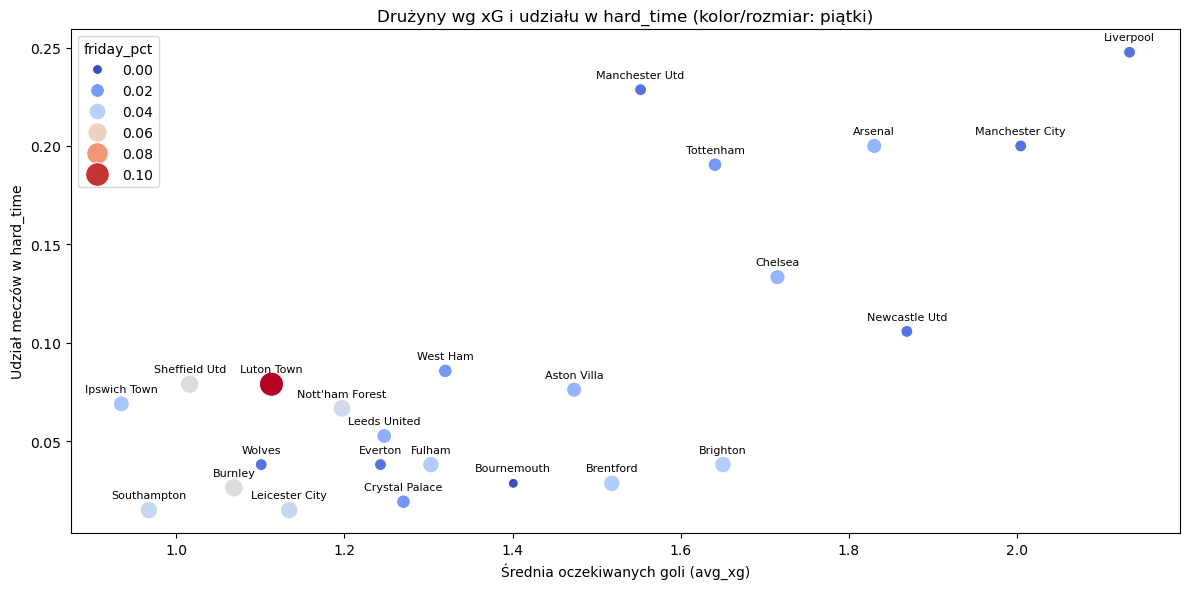

In [ ]:
plt.figure(figsize=(12, 6))

# Scatter plot
sns.scatterplot(
    data=team_stats,
    x='avg_xg',
    y='hard_time_pct',
    hue='friday_pct',
    palette='coolwarm',
    size='friday_pct',
    sizes=(50, 300),
    legend='brief'
)

# Dodajemy etykiety nazw drużyn
for _, row in team_stats.iterrows():
    plt.text(
        row['avg_xg'],
        row['hard_time_pct'] + 0.005,  # lekkie przesunięcie
        row['team'],
        ha='center',
        va='bottom',
        fontsize=8
    )

# Oznaczenia osi i tytuł
plt.xlabel('Średnia oczekiwanych goli (avg_xg)')
plt.ylabel('Udział meczów w hard_time')
plt.title('Drużyny wg xG i udziału w hard_time (kolor/rozmiar: piątki)')
plt.tight_layout()
plt.show()

              team hard_time  matches  avg_goals    avg_xg  total_matches  \
0          Arsenal        No       84   2.285714  1.872619            105   
1          Arsenal       Yes       21   1.904762  1.661905            105   
2        Liverpool        No       79   2.063291  2.073418            105   
3        Liverpool       Yes       26   2.576923  2.319231            105   
4  Manchester City        No       84   2.511905  2.111905            105   
5  Manchester City       Yes       21   1.619048  1.576190            105   
6   Manchester Utd        No       81   1.493827  1.571605            105   
7   Manchester Utd       Yes       24   1.291667  1.487500            105   
8        Tottenham        No       85   1.811765  1.577647            105   
9        Tottenham       Yes       20   2.250000  1.910000            105   

   pct_matches_hard_time  
0              80.000000  
1              20.000000  
2              75.238095  
3              24.761905  
4              80

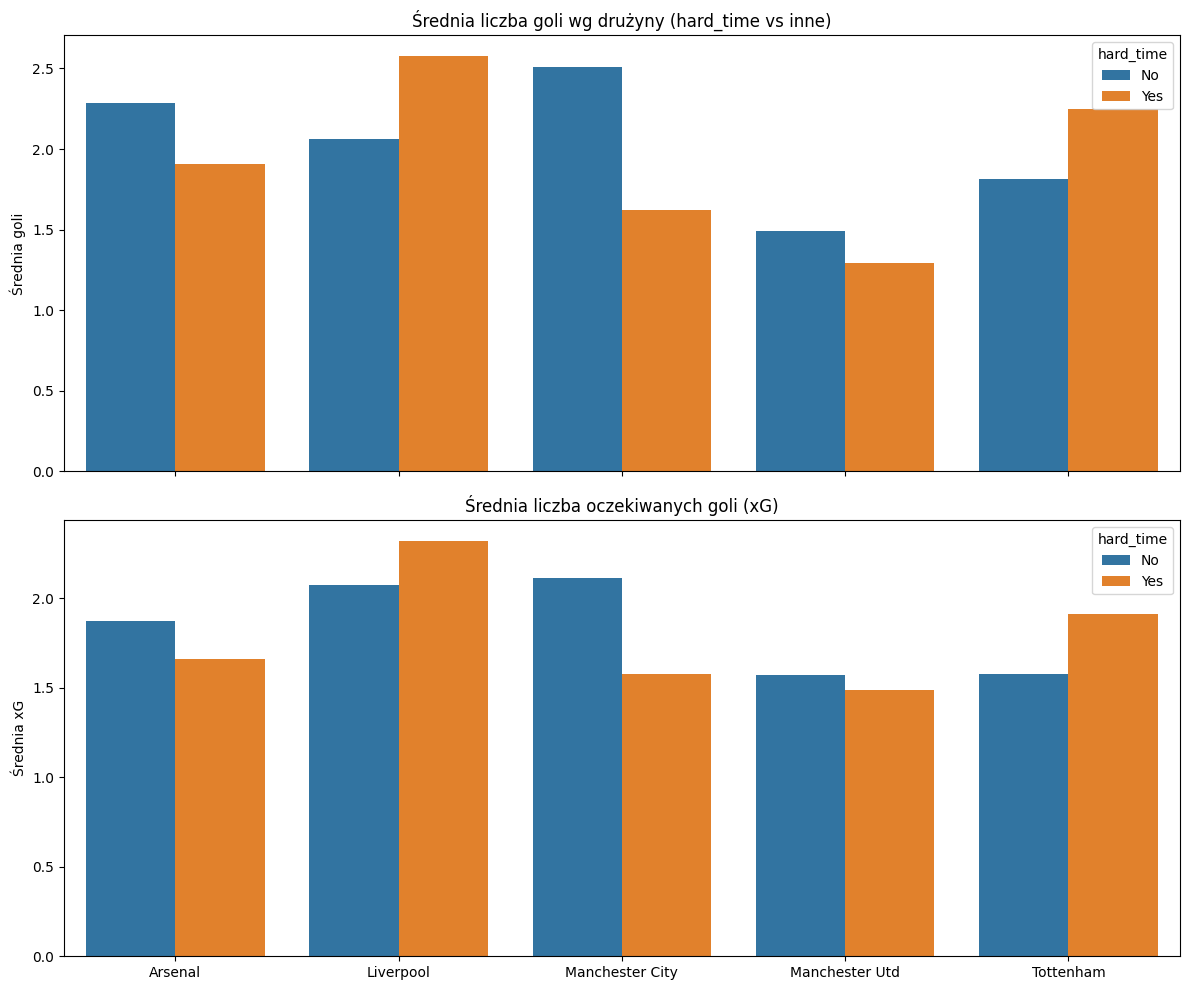

In [35]:
# Wybrane drużyny - grających dużo w hard_time 
selected_teams = [
    'Arsenal', 'Liverpool', 'Manchester City',  'Tottenham', 'Manchester Utd', # hard
 #    'Burnley', 'Sheffield Utd', 'Luton Town'  # piątek 
]

# Filtrowanie danych tylko dla tych drużyn
df_selected = df_teams[df_teams['team'].isin(selected_teams)].copy()

# Grupowanie i obliczanie statystyk oddzielnie dla hard_time = Yes i No
team_stats = df_selected.groupby(['team', 'hard_time']).agg(
    matches=('goals', 'size'),
    avg_goals=('goals', 'mean'),
    avg_xg=('xg', 'mean')
).reset_index()

# Dodawanie informacji o całkowitej liczbie meczów i udział procentowy hard_time
total_matches_team = df_selected.groupby('team').size().rename('total_matches').reset_index()
team_stats = team_stats.merge(total_matches_team, on='team')
team_stats['pct_matches_hard_time'] = (team_stats['matches'] / team_stats['total_matches']) * 100

print(team_stats)

#  Wizualizacja wyników dla porównania

fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 1) Średnie gole
sns.barplot(
    data=team_stats,
    x='team',
    y='avg_goals',
    hue='hard_time',
    ax=axs[0]
)
axs[0].set_title('Średnia liczba goli wg drużyny (hard_time vs inne)')
axs[0].set_ylabel('Średnia goli')
axs[0].set_xlabel('')

# 2) Średnie xG
sns.barplot(
    data=team_stats,
    x='team',
    y='avg_xg',
    hue='hard_time',
    ax=axs[1]
)
axs[1].set_title('Średnia liczba oczekiwanych goli (xG)')
axs[1].set_ylabel('Średnia xG')
axs[1].set_xlabel('')

plt.tight_layout()
plt.show()


## Wniosek: 
- hard time to jest raczej prime time i grają w nim lepsze drużyny. Niemniej sam termin rozgrywania meczu **nie ma wpływu** na atrakcyjność meczu

## Poszukajmy choć odrobiny prawdy w teorii o trudnym niedzielnym meczu. Zaciągnijmy statysyki ekstraklasy z lat 1989-2022

100%|██████████| 84.0k/84.0k [00:00<00:00, 1.73MB/s]

Extracting model files...


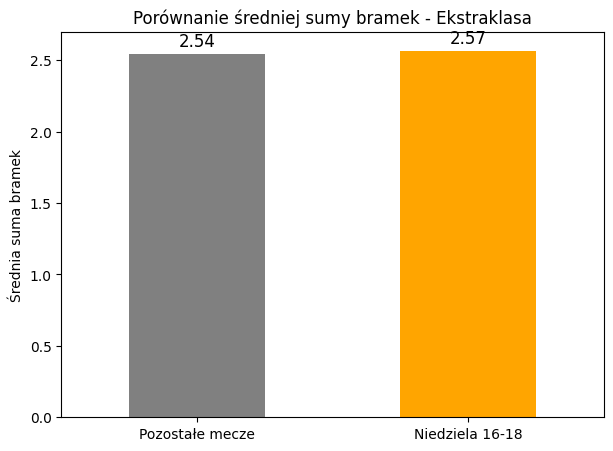

In [39]:
# 1. Pobranie i rozpakowanie zbioru danych z Kaggle
csv_path = kagglehub.dataset_download("marcinkamil84/ekstraklasa-1989-2023") + "/ekstraklasa_1989_2023.csv"

# 2. Wczytanie danych
df = pd.read_csv(csv_path)

# 3. Czyszczenie i konwersja dat + godziny
df = df.dropna(subset=['data', 'godzina', 'wynik'])  # mecze z pełną informacją
df['data'] = pd.to_datetime(df['data'], errors='coerce')
df['godzina'] = pd.to_datetime(df['godzina'], format='%H:%M', errors='coerce').dt.time

# 4. Dodanie kolumny dnia tygodnia i sumy bramek
df['day_of_week'] = df['data'].dt.day_name()
df['gole_gosp'] = df['wynik'].apply(lambda x: int(x.split(':')[0]))
df['gole_gosc'] = df['wynik'].apply(lambda x: int(x.split(':')[1]))
df['suma_bramek'] = df['gole_gosp'] + df['gole_gosc']

# 5. Filtr na niedzielę między 16:00 a 18:00
def is_between_16_18(t):
    if pd.isna(t):
        return False
    return t >= pd.to_datetime("16:00").time() and t <= pd.to_datetime("18:00").time()

df['niedziela_16_18'] = (df['day_of_week'] == 'Sunday') & df['godzina'].apply(is_between_16_18)


# 6. Grupa i średnia suma bramek dla meczów w niedzielę 16-18 i pozostałych
grupa = df.groupby('niedziela_16_18')['suma_bramek'].mean()
grupa.index = ['Pozostałe mecze', 'Niedziela 16-18']

# 7. Wykres słupkowy z wartościami średniej nad słupkami
plt.figure(figsize=(7,5))
ax = grupa.plot(kind='bar', color=['gray', 'orange'])
plt.ylabel('Średnia suma bramek')
plt.title('Porównanie średniej sumy bramek - Ekstraklasa')
plt.xticks(rotation=0)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.05, f'{height:.2f}', ha='center', fontsize=12)

plt.show()

## Panie Piotrze, proszę nam wybaczyć - staraliśmy się :)